Welcome! In this tutorial you'll learn how to solve partial differential equations with neural networks using `PyDEns`-framework. The tutorial contains a list of working examples:

* simple first-order ODE in $\mathcal{R}$
* poisson equation in $\mathcal{R}^2$
* parametric family of ODEs in $\mathcal{R}$
* parametric heat-equation with uncertainty in diffusivity in $\mathcal{R}^2 \times \mathcal{R}$
* equation with trainable coefficients in $\mathcal{R}$

## Imports and plotters

In [1]:
import sys
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
sys.path.append("../../")

In [3]:
from pydens import Solver, D, V, TorchModel, ConvBlockModel
from pydens import NumpySampler as NS

In [86]:
def plot_loss(loss):
    plt.plot(loss)
    plt.grid()
    plt.xlabel('ITERATION', fontsize=16)
    plt.ylabel('L1-loss', fontsize=16)

In [103]:
def plot_approximation_1d(points, approximation, solution_function):
    if isinstance(points, torch.Tensor):
        points = points.detach().numpy()
    if isinstance(approximation, torch.Tensor):
        approximation = approximation.detach().numpy()

    plt.plot(points, approximation, label='Neural Network approximation',
             linewidth=5, alpha=0.8)
    plt.plot(points, solution_function(points), label='Known analytical solution',
             linewidth=2)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$\hat{f}(x)$', fontsize=16)
    plt.grid()
    plt.legend(fontsize=12, loc=1)

In [109]:
def plot_approximation_2d(approximation):
    plt.imshow(approximation)
    plt.colorbar()
    plt.title(r'$\hat{f}(x, y)$', fontsize=16)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$y$', fontsize=16)

In [93]:
def cart_prod(*arrs):
    """ Get array of cartesian tuples from arbitrary number of arrays.
    """
    grids = np.meshgrid(*arrs, indexing='ij')
    return np.stack(grids, axis=-1).reshape(-1, len(arrs))

## Simple ODE in $\mathcal{R}$

$$ \frac{d f}{d x} = 2 \pi \cos{[2 \pi x]}, \quad f(0)=0.5. $$

In [62]:
def ode(f, x):
    return D(f, x) - 2 * np.pi * torch.cos(2 * np.pi * x)

In [63]:
solver = Solver(ode, ndims=1, initial_condition=.5, activation='Tanh')

In [64]:
solver.fit(niters=1500, batch_size=400)

100%|██████████| 1500/1500 [00:03<00:00, 463.28it/s]


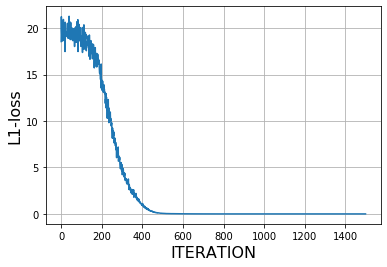

In [87]:
plot_loss(solver.losses)

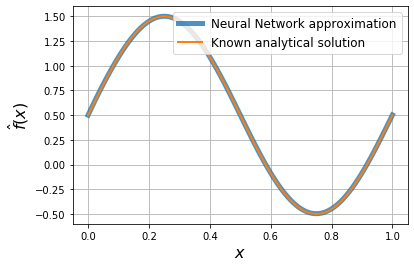

In [79]:
xs = torch.tensor(np.linspace(0, 1, 100)).float()
fs = solver.solve(xs)

plot_approximation(xs, fs, lambda x: np.sin(2 * np.pi * x) + .5)

## Poisson equation in $\mathcal{R}^2$

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 5 \sin(\pi(x + y)); \quad \quad
\\u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 1. $$

In [88]:
def pde(f, x, y):
    return D(D(f, x), x) + D(D(f, y), y) - 5 * torch.sin(np.pi * (x + y))

In [89]:
solver = Solver(pde, ndims=2, boundary_condition=1,
                model=ConvBlockModel,
                layout='fafaf', units=[10, 10, 1], activation='Tanh')

In [90]:
solver.fit(niters=500, batch_size=400, lr=0.05)

100%|██████████| 500/500 [00:02<00:00, 169.57it/s]


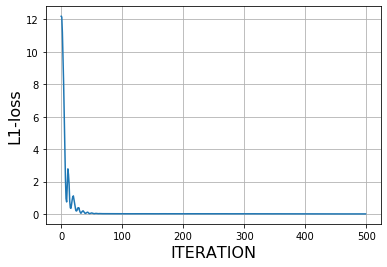

In [91]:
plot_loss(solver.losses)

In [106]:
grid = cart_prod(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

In [107]:
approxs = solver.solve(torch.tensor(grid[:, 0:1]).float(),
                       torch.tensor(grid[:, 1:2]).float()).reshape((100, 100))

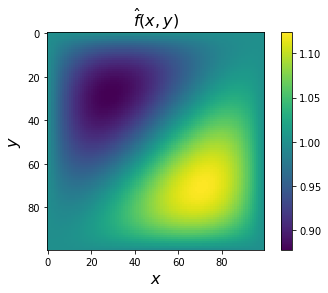

In [110]:
plot_approximation_2d(approxs)

## Parametric family of ODEs in $\mathcal{R}$

$$ \frac{d f}{d t} = \epsilon \pi \cos{[\epsilon \pi t]},\quad \epsilon \in [1, 5], \quad f(0) = 1.  \quad  \quad   \quad  \quad  \quad  $$

In [111]:
def odeparam(f, x, e):
    return D(f, x) - e * np.pi * torch.cos(e * np.pi * x)

In [112]:
solver = Solver(odeparam, ndims=1, initial_condition=2.0, nparams=1)

In [113]:
sampler = NS('u') & NS('u', low=.5, high=5.5)

In [115]:
solver.fit(niters=7000, batch_size=700, sampler=sampler, lr=0.01)

100%|██████████| 7000/7000 [00:15<00:00, 439.22it/s]


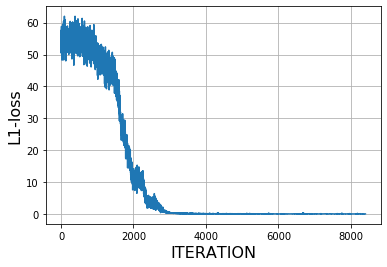

In [127]:
plot_loss(solver.losses)

In [122]:
# checking out the solution approximation for fixed epsilon
eps = 2.5
approxs = solver.solve(xs, torch.ones_like(xs) * eps)

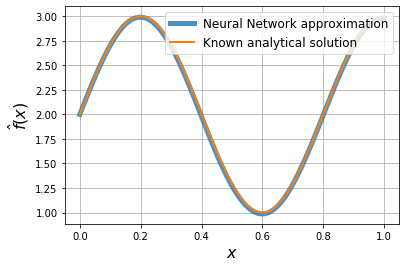

In [123]:
plot_approximation_1d(xs, approxs, lambda x: np.sin(eps * np.pi * x) + 2)

## Parametric heat-equation in $\mathcal{R}^2 \times \mathcal{R}$

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}  - a \frac{\partial u}{\partial t} = 0, \quad a \in [0.1, 4]; \quad \\
 u(x, y, t=0) = x y (1 - x) (1 - y). \quad \quad $$

In [128]:
def pde(f, x, y, t, a):
    return D(D(f, x), x) + D(D(f, y), y) - a * D(f, t)

In [129]:
solver = Solver(pde, ndims=3, nparams=1,
                initial_condition=lambda x, y: 10 * x * y * (1 - x) * (1 - y),
                boundary_condition=0, layout='fafaf', units=[30, 40, 1], activation='Sigmoid')

In [130]:
sampler = NS('u', dim=2) & NS('u', low=0, high=.5) &  NS('u', low=.1, high=4)

In [131]:
solver.fit(niters=5000, batch_size=1500, lr=0.05)

100%|██████████| 5000/5000 [01:52<00:00, 44.44it/s]


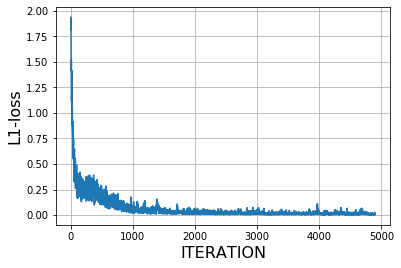

In [140]:
plot_loss(solver.losses[100:])

In [141]:
def get_approxs(t=.1, param=1.):
    grid = cart_prod(np.linspace(0, 1, 100),
                     np.linspace(0, 1, 100))

    xs, ys = torch.tensor(grid[:, 0:1]).float(), torch.tensor(grid[:, 1:2]).float()
    ts = torch.full_like(xs, t)
    ps = torch.full_like(xs, param)

    return solver.solve(xs, ys, ts, ps).reshape((100, 100))

* for fixed value of diffusivity($a$) and $t$

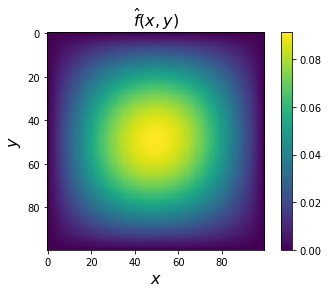

In [142]:
plot_approximation_2d(get_approxs(t=.1, ))

* gather means through time for different values of diffusivity

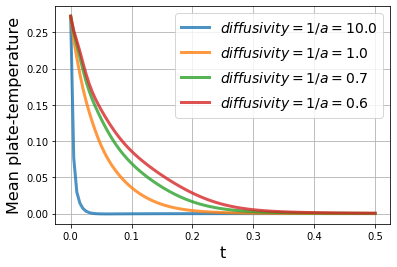

In [143]:
xs = np.linspace(0, .5, 100)
for p in [.1, 1, 1.5, 1.8]:
    plt.plot(xs, [np.mean(get_approxs(t=t, param=p)) for t in xs],
             label=fr'$diffusivity= 1 / a = {1 / p:3.1f}$', linewidth=3, alpha=0.8)
plt.legend(fontsize=14)
plt.xlabel(r't', fontsize=16)
plt.ylabel('Mean plate-temperature', fontsize=16)
plt.grid()

## ODE with trainable coefficients in $\mathcal{R}$

First-order ODE with trainable coefficient:

$$ \frac{d f}{d x} = 2 \pi \cos{[2 \pi x]} + \omega, \quad f(0)=0.5; $$
additional constraint to determine missing coefficient: $$ f(0.5)=0. $$

In [179]:
def odevar(f, x):
    return (D(f, x) - 2 * np.pi * torch.cos(2 * np.pi * x)
            + V('new_var', data=torch.Tensor([1.0])))

In [180]:
solver = Solver(odevar, ndims=1, initial_condition=1,
                constraints=lambda f, x: f(torch.tensor([0.5])))

* train the model to satisfy the equation

In [181]:
solver.model.freeze_trainable(variables=('new_var',))

In [182]:
solver.fit(niters=200, batch_size=500, lr=0.1)

100%|██████████| 200/200 [00:00<00:00, 505.50it/s]


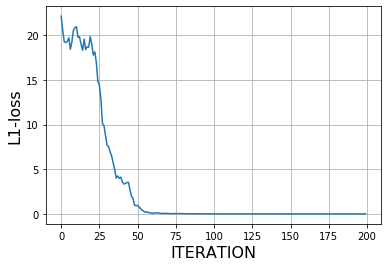

In [183]:
plot_loss(solver.losses)

In [184]:
xs = torch.Tensor(np.linspace(0, 1, 100))
approxs = solver.solve(xs)

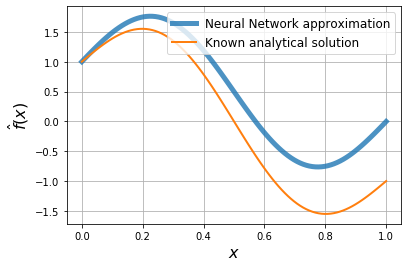

In [185]:
plot_approximation_1d(xs, approxs, lambda x: np.sin(2 * np.pi * x) + 1 - 2 * x)

* train the variable to satisfy additional constraint

In [186]:
solver.model.unfreeze_trainable(variables=['new_var'])

In [187]:
solver.fit(niters=100, batch_size=100, lr=0.1,
           losses=['equation', 'constraint_0'])

  0%|          | 0/100 [00:00<?, ?it/s]/Users/aleksandr/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:00<00:00, 391.29it/s]


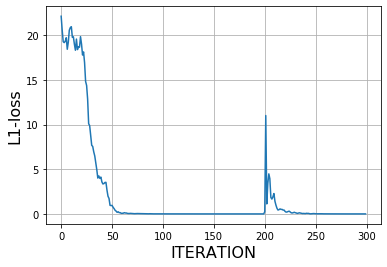

In [188]:
plot_loss(solver.losses)

In [189]:
approxs = solver.solve(xs)

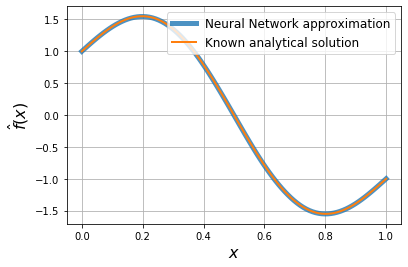

In [192]:
plot_approximation_1d(xs, approxs,
                      solution_function=lambda x: np.sin(2 * np.pi * x) + 1 - 2 * x)